### Passo 1: Gerando a Série


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
np.random.seed(42)
n = 500
# criacao da serie perfeita
trend = np.linspace( 0, 0, n)
noise = np.random.normal( 0, 1, n)
serie_perfeita = trend + noise


<Axes: ylabel='serie_final'>

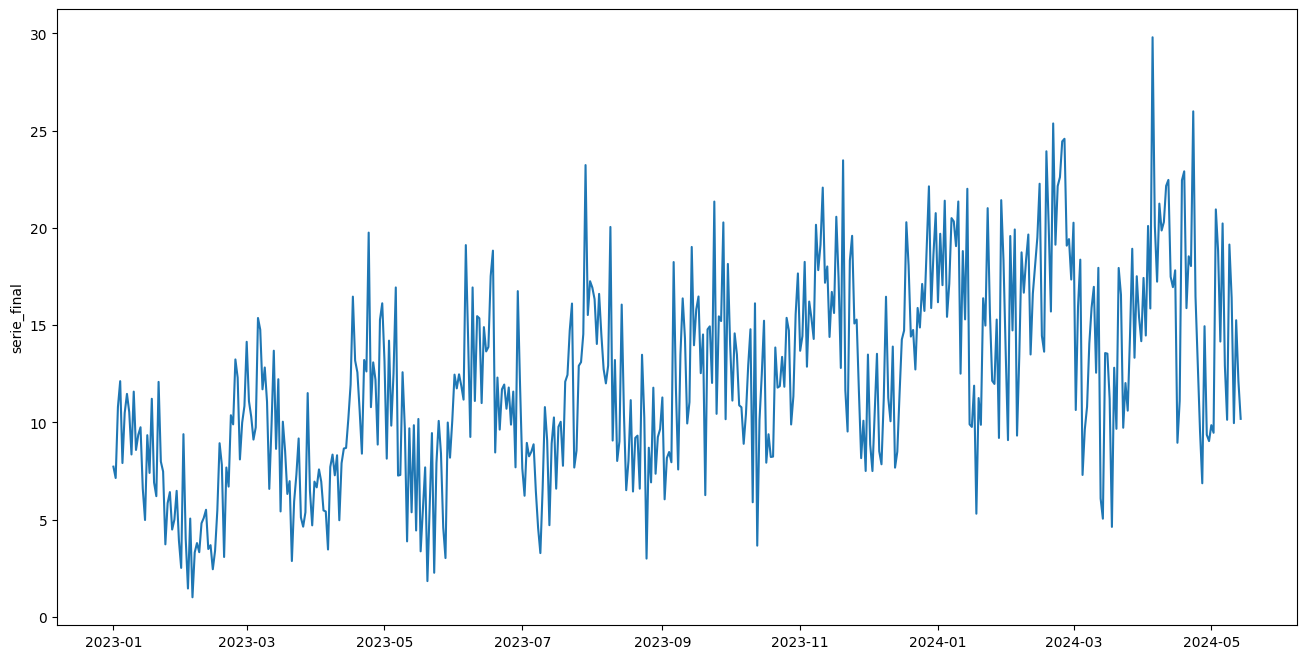

In [2]:
dates = pd.date_range( start='2023-01-01', periods=n, freq='D' )
serie_perfeita = pd.Series( serie_perfeita, index=dates, name='serie_perfeita' )

# quebra premissa 1: linearidade
trend_break = np.linspace( 0, 10, n )
serie_nao_linear = serie_perfeita + trend_break

# quebra premissa 2: estacionariedade
seasonality = 3 * np.sin( 2 * np.pi * np.arange( n ) / 50 )
serie_nao_estacionaria = serie_perfeita + seasonality

# quebra premissa 3: autocorrelacao
autoregressive = np.zeros( n)
autoregressive[0] = noise[0]
for t in range( 1, n ):
 autoregressive[t] = 0.8 * autoregressive[t-1] + np.random.normal( 0, 0.5)
serie_nao_autocorrelacao = serie_perfeita + autoregressive

# quebra premissa 4: homocedasticidade
non_normal = noise * np.linspace( 1, 3, n )
serie_nao_homocedastica = serie_perfeita + non_normal

# quebra premissa 5: nao normalidade
non_normal_noise = np.random.exponential( 1, n )
serie_nao_normal = serie_perfeita + non_normal_noise

# combinar as series
serie_final = (
 serie_perfeita
 + trend_break
 + seasonality
 + autoregressive
 + non_normal
 + non_normal_noise
)
serie_final = pd.Series( serie_final, index=dates, name='serie_final' )

serie_final = serie_final - serie_final.min() + 1
# visualizacao das series
plt.figure( figsize=(16, 8) )
sns.lineplot( serie_final )

### Passo 2: Separação Train-Test-Validação

In [3]:
train_size = int( 0.8 * len( serie_final ) )
validation_size = int( 0.1 * len( serie_final ) )

# split
train = serie_final[:train_size]
validation = serie_final[train_size:train_size + validation_size]
test = serie_final[train_size + validation_size:]


### Passo 3: Teste Estacionariedade

In [4]:
# test adfuller
adf_test = adfuller( train )

# Exibir os resultados do teste
print("Resultado do Teste de Dickey-Fuller:")
print(f"Estatística ADF: {adf_test[0]:.4f}")
print(f"Valor-p: {adf_test[1]:.4f}")

# Interpretação do teste
if adf_test[1] > 0.05:
 print("\nA série NÃO é estacionária (não rejeitamos H0).")
else:
 print("\nA série é estacionária (rejeitamos H0).")

Resultado do Teste de Dickey-Fuller:
Estatística ADF: -2.6362
Valor-p: 0.0858

A série NÃO é estacionária (não rejeitamos H0).


### Passo 4: Transformando a série em Estacionária


In [5]:
serie_diferenciada = train.diff().dropna()
adf_test = adfuller( serie_diferenciada )

# Exibir os resultados do teste
print("Resultado do Teste de Dickey-Fuller:")
print(f"Estatística ADF: {adf_test[0]:.4f}")
print(f"Valor-p: {adf_test[1]:.4f}")

# Interpretacao do teste
if adf_test[1] > 0.05:
 print( "\nA série NÃO é estacionária (não rejeitamos H0).")
else:
 print( "\nA série é estacionária (rejeitamos H0).")

Resultado do Teste de Dickey-Fuller:
Estatística ADF: -12.5578
Valor-p: 0.0000

A série é estacionária (rejeitamos H0).


### Passo 5: Teste PACF e ACF


<Figure size 1200x600 with 0 Axes>

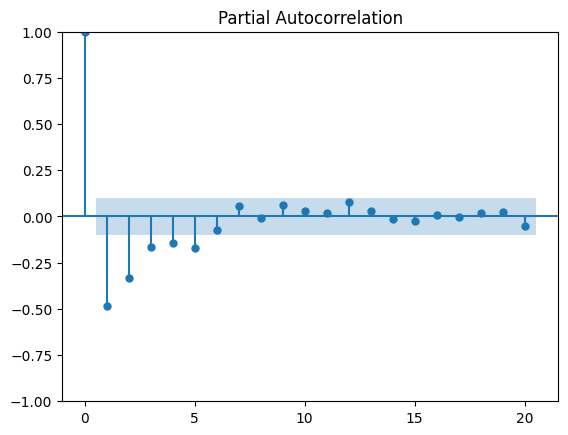

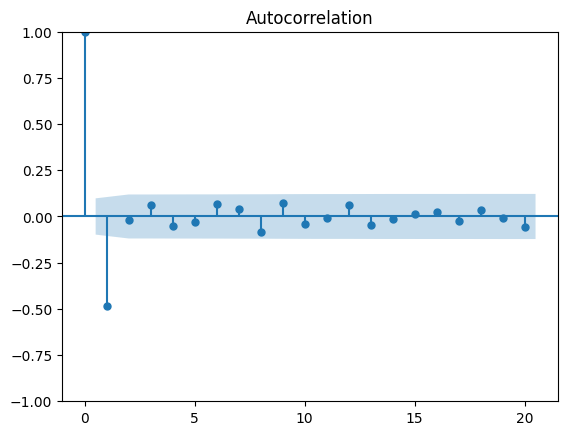

In [21]:
# teste PACF
plt.figure( figsize=(12, 6) )
plot_pacf( serie_diferenciada, lags=20 );
# teste ACF
plot_acf( serie_diferenciada, lags=20 );



Aula 25 - Modelo testado 

In [22]:
# parametros
p, d, q = 6, 1, 2 

In [19]:
# Fine Tuning
p_values = [5, 6, 7]
q_values = [2, 3]
d_values = [1]
num_iterations = 2
results_val = pd.DataFrame()
for _ in range( num_iterations ):
 p = int( np.random.choice( p_values ) )
 q = int( np.random.choice( q_values ) )
 d = int( np.random.choice( d_values ) )
 print( f'Testando parâmetro: p, d, q={p, d, q}' )
 predictions = []
 actuals = []
 train_series = train.copy()
 for t in range( len( validation ) ):
    # model definition
    model = ARIMA( train_series, order=(p,d,q) )
    # model training
    model_fit = model.fit()
    # forecast
    forecast = model_fit.forecast( steps=1 ).iloc[0]
    # store predictions
    predictions.append( forecast)
    actuals.append( validation.iloc[t])
    # update training
    train_series = pd.concat( [train_series, pd.Series(validation.iloc[t], index=[validation.index[t]])] )
                                                       
 # prediction x actuals
 df_val = pd.DataFrame( {"Predictions": predictions, "Actuals": actuals} )

 # compute metrics
 errors = df_val['Actuals'] - df_val['Predictions']
 rmse_val = np.sqrt( np.mean( errors**2 ) )
 mae_val = np.mean( np.abs( errors ) )
 mape_val = np.mean( np.abs( errors / df_val['Actuals'] ) )
 log_likelihood = model_fit.llf
 num_obs = len( train_series )
 num_params = model_fit.params.shape[0]
 aic_val = -2 * log_likelihood + 2 * num_params
 bic_val = -2 * log_likelihood + num_params * np.log( num_obs )
 # store results
 performance = pd.DataFrame( {"P": p, "D": d, "Q": q,
 "RMSE_VAL": rmse_val ,
 "MAE_VAL": mae_val,
 "MAPE_VAL": mape_val,
 "AIC_VAL": aic_val,
 "BIC_VAL": bic_val } , index=[0] )
 results_val = pd.concat( [results_val, performance] )
results_val.sort_values( "RMSE_VAL", ascending=True )


Testando parâmetro: p, d, q=(7, 1, 3)


c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so 

Testando parâmetro: p, d, q=(5, 1, 2)


c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppDa

,P,D,Q,RMSE_VAL,MAE_VAL,MAPE_VAL,AIC_VAL,BIC_VAL
0,5,1,2,4.374953,3.559070,0.308484,2390.428346,2423.302327
0,7,1,3,4.475852,3.676539,0.316388,2394.749798,2439.951521


In [23]:
# previsao do test
p, d, q = 5, 1, 3
predictions = []
actuals = []
results_test = pd.DataFrame()
train_series = pd.concat( [train, validation] )
for t in range( len( test ) ):
 # model definition
 model = ARIMA( train_series, order=(p,d,q) )

 # model training
 model_fit = model.fit()

 # forecast
 forecast = model_fit.forecast( steps=1 ).iloc[0]

 # store predictions
 predictions.append( forecast )
 actuals.append( test.iloc[t])

 # update training
 train_series = pd.concat( [train_series, pd.Series(test.iloc[t], index=[test.index[t]])] )

# prediction x actuals
df_test = pd.DataFrame( {"Predictions": predictions, "Actuals": actuals } )
df_test.index = test.index

# compute metrics
erros = df_test['Actuals'] - df_test['Predictions']
rmse_test = np.sqrt( np.mean( errors**2 ) )
mae_test = np.mean( np.abs( errors ) )
mape_test = np.mean( np.abs( errors / df_test['Actuals'] ) )
log_likelihood = model_fit.llf
num_obs = len( train_series )
num_params = model_fit.params.shape[0]
aic_test = -2 * log_likelihood + 2 * num_params
bic_test = -2 * log_likelihood + num_params * np.log( num_obs )
performance = pd.DataFrame( {"Q": q, "P": p, "D": d,
 "RMSE_TEST": rmse_test ,
 "MAE_TEST": mae_test,
 "MAPE_TEST": mape_test,
 "AIC_TEST": aic_test,
 "BIC_TEST": bic_test } , index=[0] )
results_test = pd.concat( [results_test, performance] )
results_test

c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users

,Q,P,D,RMSE_TEST,MAE_TEST,MAPE_TEST,AIC_TEST,BIC_TEST
0,3,5,1,4.374953,3.55907,NaN,2700.39987,2738.331343


### Passo 8: Visualização dos dados



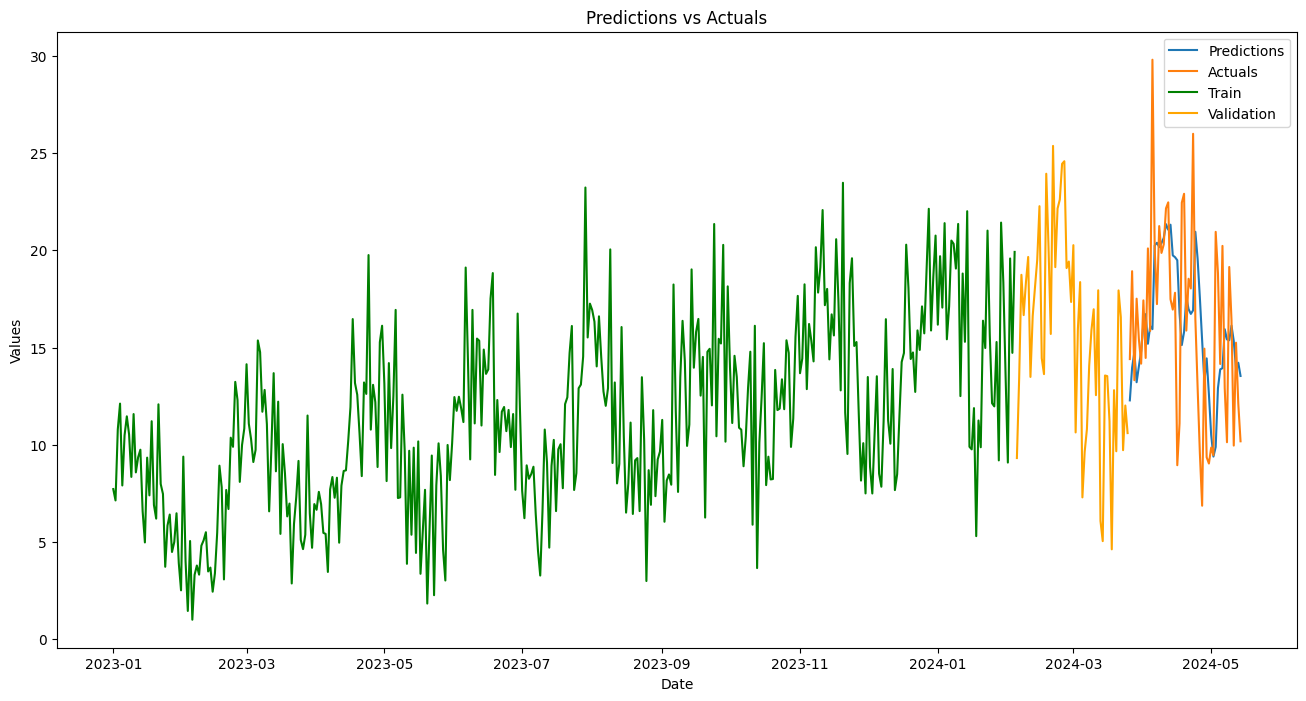

In [15]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=df_test.index, y=df_test['Predictions'], label='Predictions')
sns.lineplot(x=df_test.index, y=df_test['Actuals'], label='Actuals')
sns.lineplot(x=train.index, y=train, label='Train', color='green')
sns.lineplot(x=validation.index, y=validation, label='Validation', color='orange')

plt.title('Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
